## TODOs:

### Drop useless features
  * venue
  * wind_speed
  * game_page_url
  * start_time

### Use Quartiles to label different attendance levels
  * 0-25%: Low
  * 25-50%: Medium
  * 50-75%: High
  * 75-100%: Very High
### Use common dimensionality reduction techniques:
  * PCA
  * MDS
  * LLE
    * use 20, 40 neighbors
    * perform PCA transformation first and use first 20 components
  * Kernel PCA
    * RBF
    * Cosine
  * t-SNE
    * Euclidian
    * Cosine
    * Jaccard

In [1]:
import pandas as pd

trainset = pd.read_csv("processed_training_final.csv")
testset = pd.read_csv("processed_test_final.csv")

print(trainset.shape)
print(testset.shape)

(12270, 220)
(2445, 220)


In [2]:
trainset.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,season,home_team_avg_att_last_year,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon,game_page_url,start_time,previous_5_to_10MA
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,2015,0.345307,19,0,1,0,0,https://www.baseball-reference.com/boxes/CHN/C...,2015-04-05 19:17:00,32742.135802
1,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,2015,0.766348,13,0,0,0,1,https://www.baseball-reference.com/boxes/DET/D...,2015-04-06 13:08:00,36014.925926
2,45909,0,Safeco Field,1,-1.842921,-1.281036,LAA,-1.62645,-1.654514,0.0,...,2015,-0.588237,13,0,0,0,1,https://www.baseball-reference.com/boxes/SEA/S...,2015-04-06 13:12:00,25485.604938
3,53518,0,Dodger Stadium,1,-0.804795,-1.281036,SDP,-1.62645,-1.654514,0.0,...,2015,2.140393,13,0,0,0,1,https://www.baseball-reference.com/boxes/LAN/L...,2015-04-06 13:12:00,46695.518519
4,48469,0,Yankee Stadium III,1,-1.842921,-0.489072,TOR,-1.62645,-1.654514,0.0,...,2015,1.603257,13,0,0,0,1,https://www.baseball-reference.com/boxes/NYA/N...,2015-04-06 13:13:00,42520.300000


In [3]:
# create a list to store the level of attendance for each game, the level is divided by quartile
# 0: 0-25%
# 1: 25-50%
# 2: 50-75%
# 3: 75-100%
train_attendance_level = []
attendance_quartiles = trainset['attendance'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()

def get_attendance_level(attendance):
    if attendance <= attendance_quartiles[1]:
        return 0
    elif attendance <= attendance_quartiles[2]:
        return 1
    elif attendance <= attendance_quartiles[3]:
        return 2
    else:
        return 3

for attendance in trainset['attendance']:
    train_attendance_level.append(get_attendance_level(attendance))

print(f"the level distribution of attendance is \n{pd.Series(train_attendance_level).value_counts()}")

the level distribution of attendance is 
0    3069
3    3068
1    3067
2    3066
dtype: int64


In [36]:
# try to use PCA to reduce only player one-hot features to 2 dimensions and visualize the result with attendance level to see if there is any pattern

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib


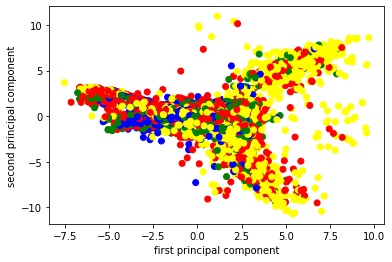

In [39]:
player_one_hot_features = trainset.iloc[:, 16:184]

# standardize the data
scaler = StandardScaler()
player_one_hot_features = scaler.fit_transform(player_one_hot_features)

# use PCA to reduce the dimension to 2
pca = PCA(n_components=8)
player_one_hot_features = pca.fit_transform(player_one_hot_features)

# visualize the result
# in train_attendance_level, 0: 0-25%, 1: 25-50%, 2: 50-75%, 3: 75-100%
# we use different color to represent different level, 0 is blue, 1 is green, 2 is red, 3 is yellow
colors = ['blue', 'green', 'red', 'yellow']
plt.scatter(player_one_hot_features[:, 0], player_one_hot_features[:, 1], c=train_attendance_level, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()


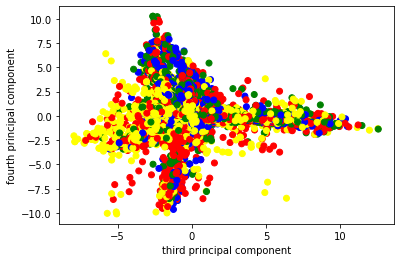

In [41]:
plt.scatter(player_one_hot_features[:, 2], player_one_hot_features[:, 3], c=train_attendance_level, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('third principal component')
plt.ylabel('fourth principal component')
plt.show()

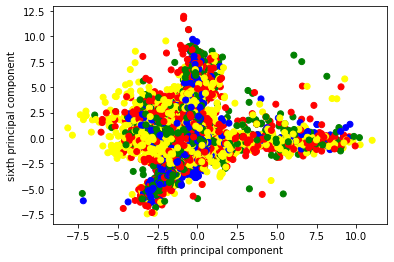

In [42]:
plt.scatter(player_one_hot_features[:, 4], player_one_hot_features[:, 5], c=train_attendance_level, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('fifth principal component')
plt.ylabel('sixth principal component')
plt.show()

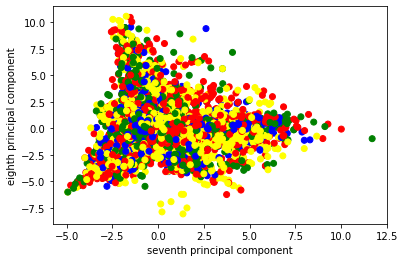

In [43]:
plt.scatter(player_one_hot_features[:, 6], player_one_hot_features[:, 7], c=train_attendance_level, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('seventh principal component')
plt.ylabel('eighth principal component')
plt.show()

From above four pictures, we don't see any obvious clusters. Let's try different dimensionality reduction techniques.

MDS

In [34]:
player_one_hot_features = trainset.iloc[:, 16:184]
category_names = {0: "0-25%", 1: "25-50%", 2: "50-75%", 3: "75-100%"}
att_level = pd.Series(train_attendance_level)
att_level = att_level.map(category_names)
category_names = list(category_names.values())

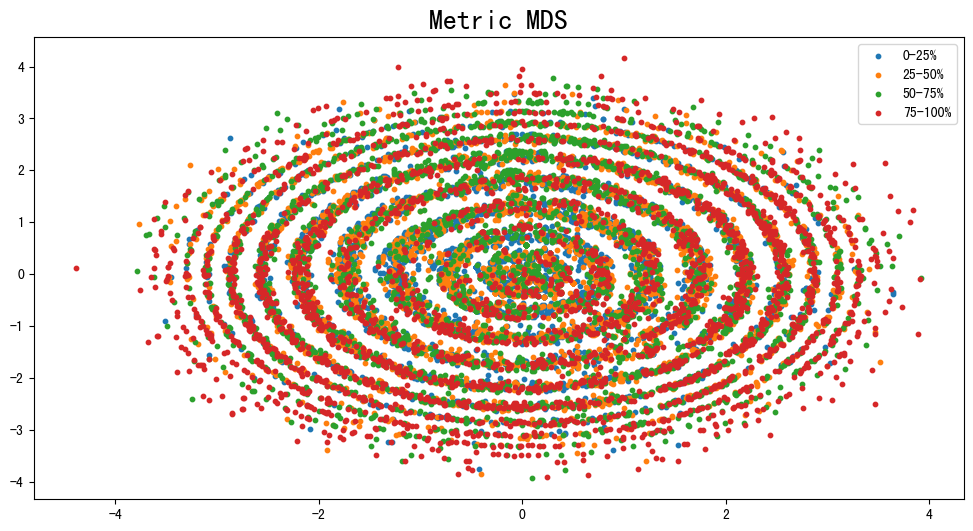

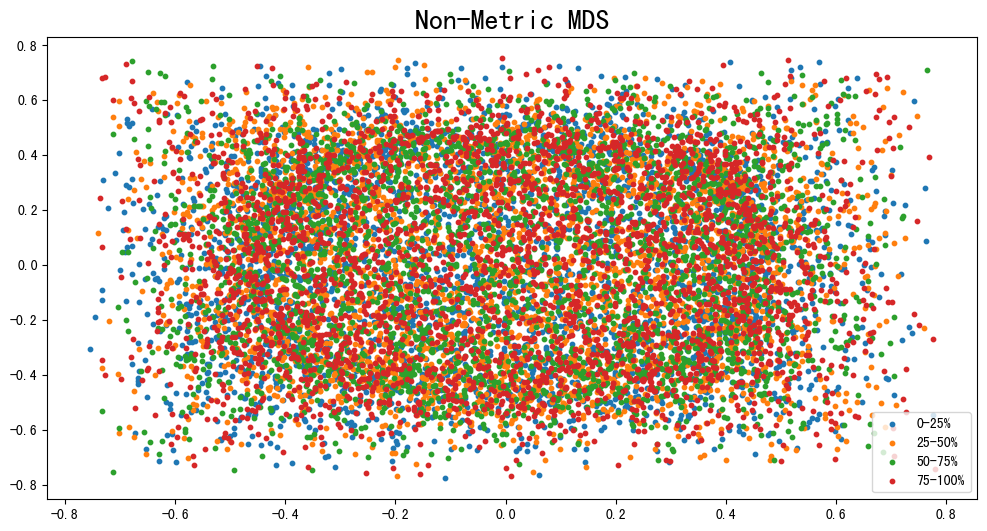

In [35]:
# use MDS to reduce dimensionality and plot scatter plot
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

mds = MDS(n_components=2, metric=True)
mds = mds.fit_transform(player_one_hot_features)

plt.figure(figsize = (12,6))
plt.title('Metric MDS', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   plt.scatter(mds[indicesToKeep, 0]
               , mds[indicesToKeep, 1]
               , s = 10)
plt.legend(category_names )
plt.show()

mds = MDS(n_components=2, metric=False)
mds = mds.fit_transform(player_one_hot_features)

plt.figure(figsize = (12,6))
plt.title('Non-Metric MDS', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   plt.scatter(mds[indicesToKeep, 0]
               , mds[indicesToKeep, 1]
               , s = 10)
plt.legend(category_names)
plt.show()

LLE

In [37]:
# using LLE with 20 neighbors to reduce dimensionality
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA

d1 = LocallyLinearEmbedding(n_components=2, n_neighbors=20)
d1 = d1.fit_transform(player_one_hot_features)

d2 = LocallyLinearEmbedding(n_components=2, n_neighbors=40)
d2 = d2.fit_transform(player_one_hot_features)

pca = PCA(n_components=100)
pcs = pca.fit_transform(player_one_hot_features)
d3 = LocallyLinearEmbedding(n_components=2, n_neighbors=40)
d3 = d3.fit_transform(pcs)

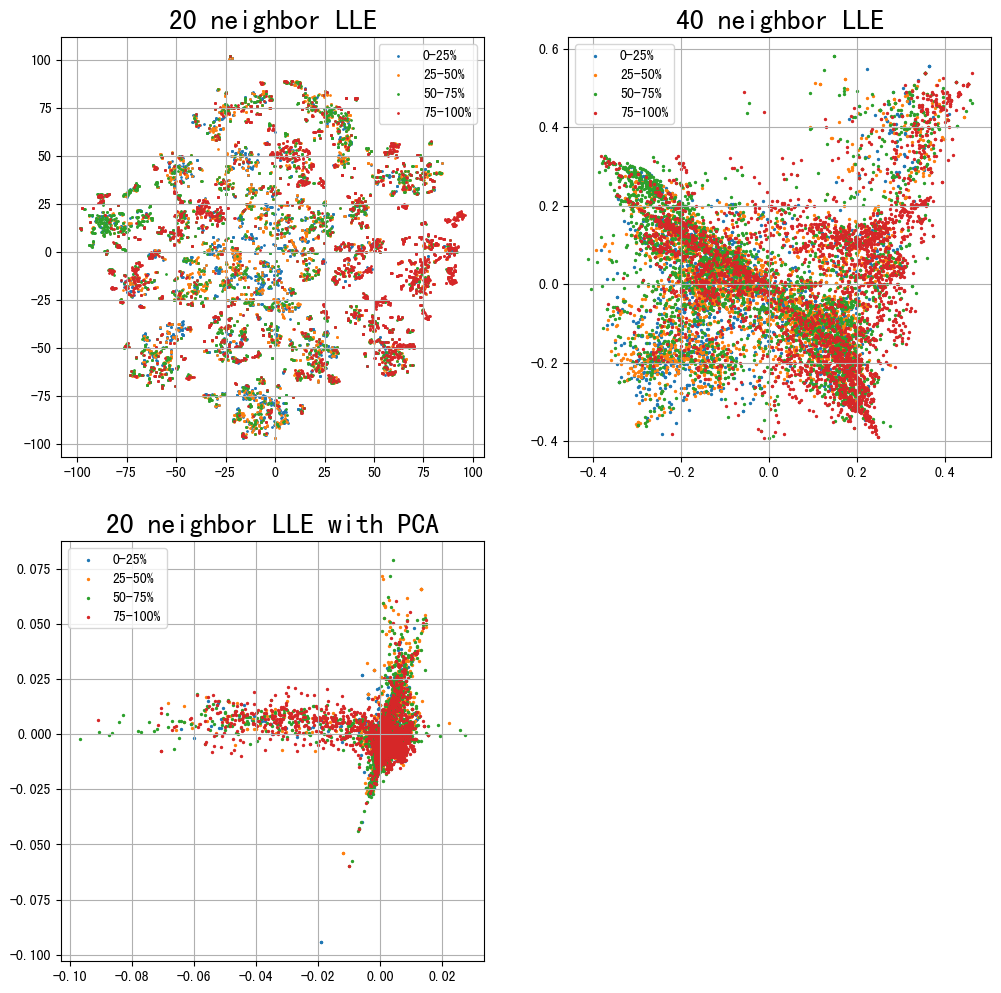

In [54]:
fig = plt.figure(figsize = (12,12))

ax = fig.add_subplot(2,2,1) 
ax.set_title('20 neighbor LLE', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d1[indicesToKeep, 0]
               , d1[indicesToKeep, 1]
               , s = 1)
ax.legend(category_names)
ax.grid()

ax = fig.add_subplot(2,2,2) 
ax.set_title('40 neighbor LLE', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d2[indicesToKeep, 0]
               , d2[indicesToKeep, 1]
               , s = 2)
ax.legend(category_names)
ax.grid()

ax = fig.add_subplot(2,2,3) 
ax.set_title('20 neighbor LLE with PCA', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d3[indicesToKeep, 0]
               , d3[indicesToKeep, 1]
               , s = 2)
ax.legend(category_names)
ax.grid()

KernalPCA

In [39]:
from sklearn.decomposition import KernelPCA

kernel1 = KernelPCA(n_components=2, kernel='rbf')
d1 = kernel1.fit_transform(player_one_hot_features)

kernel2 = KernelPCA(n_components=2, kernel='cosine')
d2 = kernel2.fit_transform(player_one_hot_features)



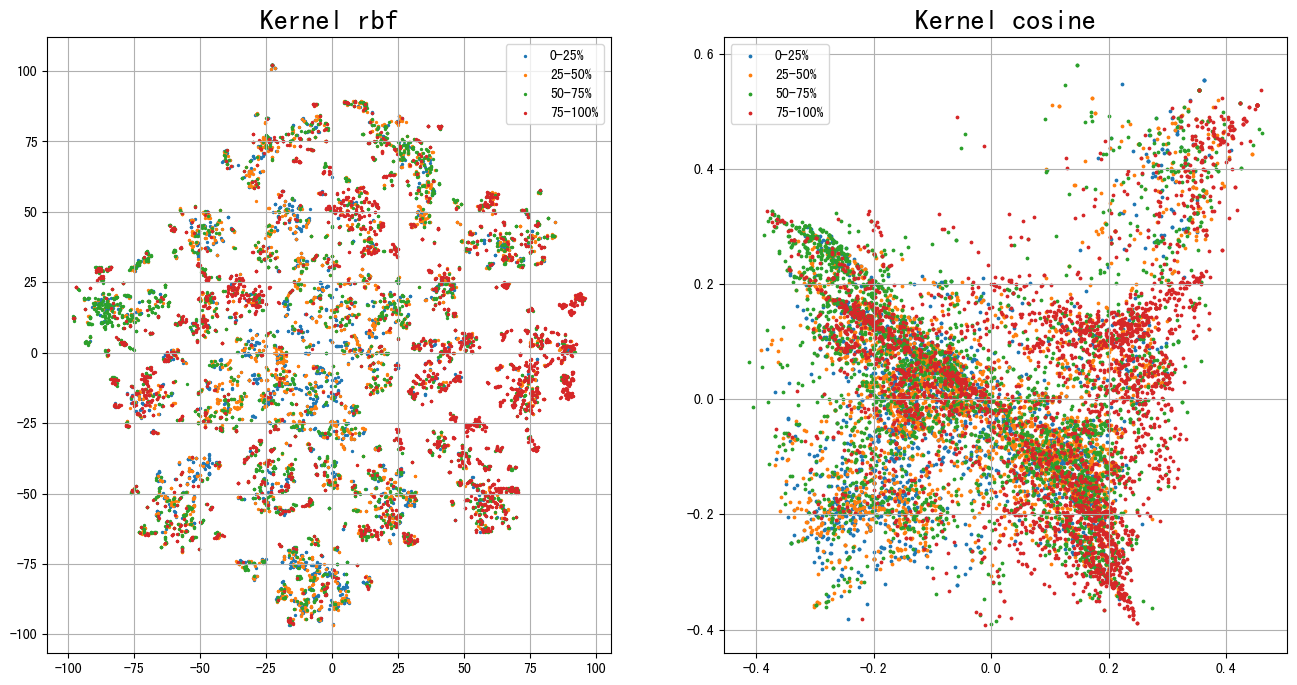

In [51]:
fig = plt.figure(figsize = (16, 8))

ax = fig.add_subplot(1,2,1) 
ax.set_title('Kernel rbf', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d1[indicesToKeep, 0]
               , d1[indicesToKeep, 1]
               , s = 2)
ax.legend(category_names)
ax.grid()

ax = fig.add_subplot(1,2,2) 
ax.set_title('Kernel cosine', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d2[indicesToKeep, 0]
               , d2[indicesToKeep, 1]
               , s = 3)
ax.legend(category_names)
ax.grid()

TSNE

In [41]:
from sklearn.manifold import TSNE

ds = []

tsne = TSNE(n_components=2, metric='euclidean', random_state=42)
d1 = tsne.fit_transform(player_one_hot_features)
ds.append(d1)

tsne = TSNE(n_components=2, metric='cosine', random_state=42)
d1 = tsne.fit_transform(player_one_hot_features)
ds.append(d1)

tsne = TSNE(n_components=2, metric='jaccard', random_state=42)
d1 = tsne.fit_transform(player_one_hot_features)
ds.append(d1)


/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: Future

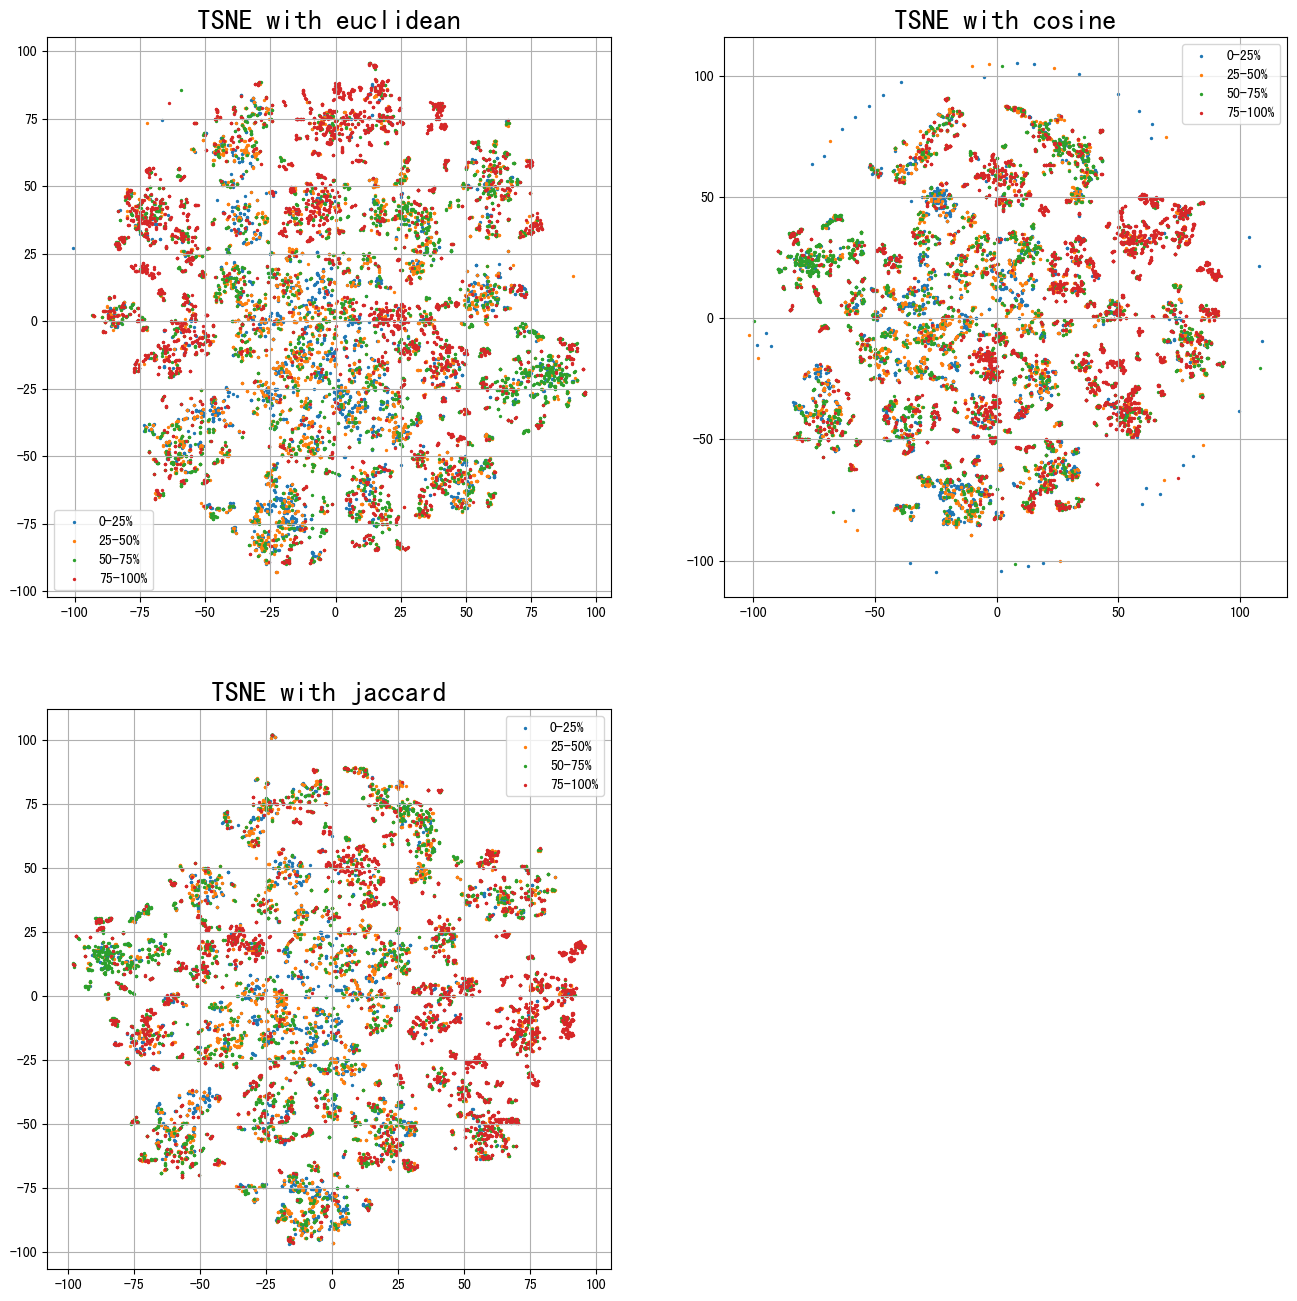

In [46]:
fig = plt.figure(figsize = (16, 16))

for i,( d, title) in enumerate(zip(ds, ['TSNE with euclidean','TSNE with cosine','TSNE with jaccard']), 1):
    ax = fig.add_subplot(2,2,i) 
    ax.set_title(title, fontsize = 20)
    for category_name in category_names:
        indicesToKeep = att_level == category_name
        ax.scatter(d[indicesToKeep, 0]
                    , d[indicesToKeep, 1]
                    , s = 2)
    ax.legend(category_names)
    ax.grid()